In [47]:
import numpy as np
import matplotlib.pyplot as plt
# !matplotlib inline
from sklearn.datasets import fetch_openml

In [48]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [49]:
print(type(mnist.data))
mnist.data[0]

<class 'numpy.ndarray'>


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [50]:
mnist.target[0]

'5'

In [51]:
mnist.target = mnist.target.astype(np.int8)

In [52]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

이 이미지 데이터의 레이블은 5이다


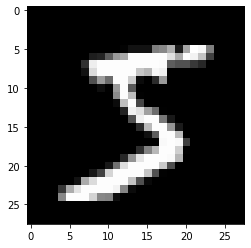

In [53]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

# 2. 훈련데이터와 테스트 데이터의 분리

In [54]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

# 3. 다층 퍼셉트론

In [55]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [56]:
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [57]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))

In [60]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가
            print('predicted : \n', predicted)
            print('targets.data.view_as(predicted) : \n', targets.data.view_as(predicted))
            print('predicted.eq(targets.data.view_as(predicted)) : \n', predicted.eq(targets.data.view_as(predicted)))
    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [62]:

print(test())

predicted : 
 tensor([9, 5, 5, 9, 5, 7, 5, 4, 5, 5, 4, 5, 7, 6, 5, 7, 5, 5, 4, 5, 9, 9, 5, 5,
        5, 5, 9, 5, 5, 5, 5, 5, 9, 6, 7, 5, 5, 5, 5, 5, 9, 5, 5, 7, 9, 9, 5, 5,
        5, 7, 5, 5, 5, 5, 5, 5, 9, 9, 5, 5, 5, 5, 5, 5])
targets.data.view_as(predicted) : 
 tensor([0, 4, 1, 2, 7, 9, 7, 1, 1, 7, 1, 3, 4, 2, 6, 4, 6, 7, 3, 3, 7, 0, 5, 7,
        6, 5, 6, 4, 7, 4, 3, 5, 0, 1, 4, 6, 3, 9, 4, 5, 8, 0, 9, 6, 0, 9, 7, 5,
        7, 1, 0, 1, 3, 5, 5, 0, 5, 0, 0, 3, 7, 5, 1, 8])
predicted.eq(targets.data.view_as(predicted)) : 
 tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,  True,
        False, False, False, False, False,  True, False,  True, False, False,
        False, False, False,  True,  True, False, False, False, False, False

In [63]:
for epoch in range(3):
    train(epoch)

test()

epoch0：완료

epoch1：완료

epoch2：완료

predicted : 
 tensor([0, 4, 1, 2, 7, 9, 7, 1, 1, 7, 1, 3, 4, 2, 8, 4, 6, 7, 7, 3, 7, 0, 5, 7,
        6, 5, 6, 4, 7, 4, 3, 5, 0, 1, 4, 6, 3, 9, 4, 5, 8, 0, 9, 6, 0, 9, 7, 5,
        7, 1, 0, 1, 3, 5, 5, 0, 5, 0, 0, 3, 7, 5, 1, 8])
targets.data.view_as(predicted) : 
 tensor([0, 4, 1, 2, 7, 9, 7, 1, 1, 7, 1, 3, 4, 2, 6, 4, 6, 7, 3, 3, 7, 0, 5, 7,
        6, 5, 6, 4, 7, 4, 3, 5, 0, 1, 4, 6, 3, 9, 4, 5, 8, 0, 9, 6, 0, 9, 7, 5,
        7, 1, 0, 1, 3, 5, 5, 0, 5, 0, 0, 3, 7, 5, 1, 8])
predicted.eq(targets.data.view_as(predicted)) : 
 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, 

예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


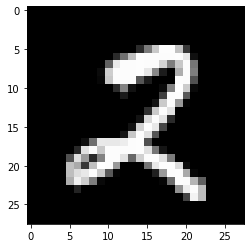

In [64]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))
